# Time Series Classification
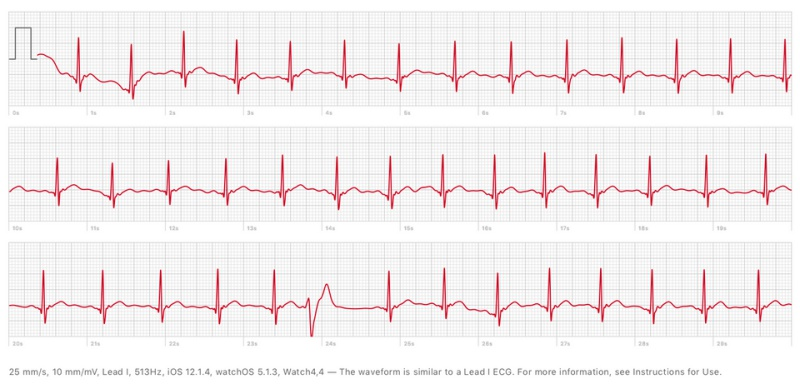

# Setup

In [40]:
#!conda install tslearn --yes

In [41]:
#!conda install tsfresh --yes

In [42]:
#!conda install cesium --yes

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import itertools
import requests
import zipfile
import collections
from collections import Counter
from scipy.stats import mode

import xgboost as xgb
from xgboost import XGBClassifier

import yellowbrick
from yellowbrick.classifier import ConfusionMatrix

import tslearn
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

# Data
* Released in 2002
* Resource for Time Series Mining


In [229]:
X_train_raw, y_train, X_test_raw, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')

## Size

In [230]:
print(f'Training Set Size: {X_train_raw.shape}')
print(f'Test     Set Size: {X_test_raw.shape}')

Training Set Size: (1000, 128, 1)
Test     Set Size: (4000, 128, 1)


In [231]:
X_train = pd.DataFrame(np.squeeze(X_train_raw))
X_test  = pd.DataFrame(np.squeeze(X_test_raw))

## Class Balance

In [232]:
counter = Counter(y_train)
counter

Counter({2: 237, 3: 250, 4: 242, 1: 271})

# Plots

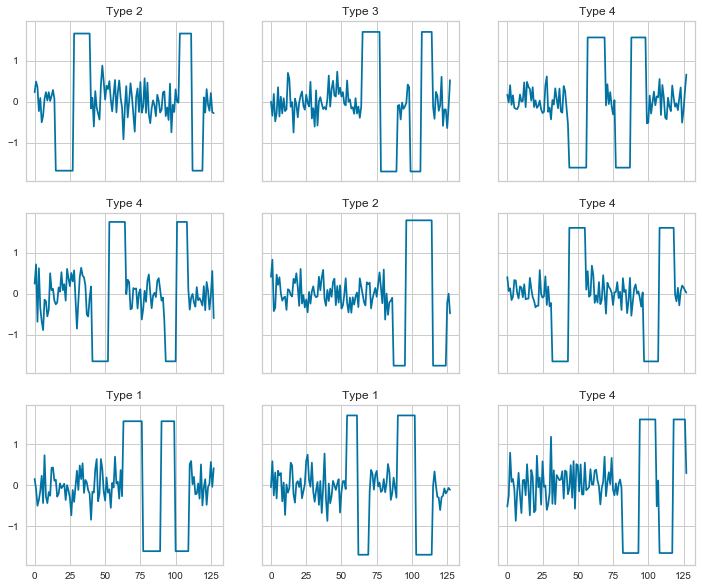

In [233]:
f, ax = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12, 10))
for index in range(9):
    ax[index // 3, index % 3].plot(X_train_raw[index])
    ax[index // 3, index % 3].set_title('Type {}'.format(y_train[index]))

## Histogram

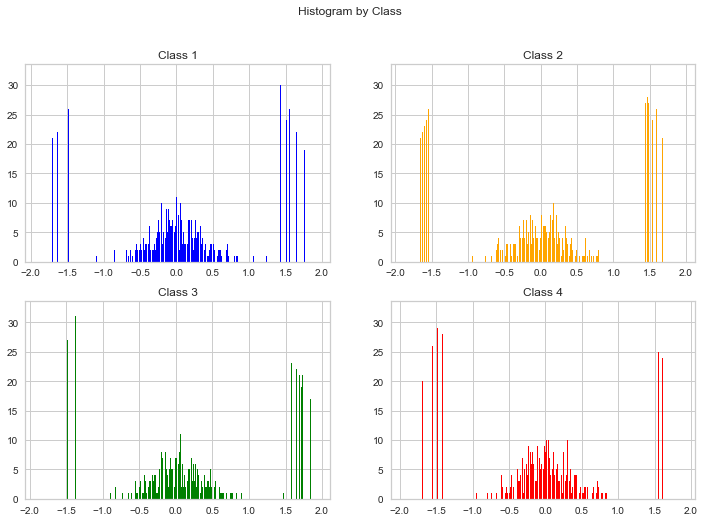

In [244]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Histogram by Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    length = (y_train == index + 1).sum()
    ax[x, y].hist(X_train[y_train == index + 1], color=([colors[index]] * length), bins=int(X_train.shape[1] / 2))
    ax[x, y].title.set_text(f'Class {index + 1}')

## 2D Histogram

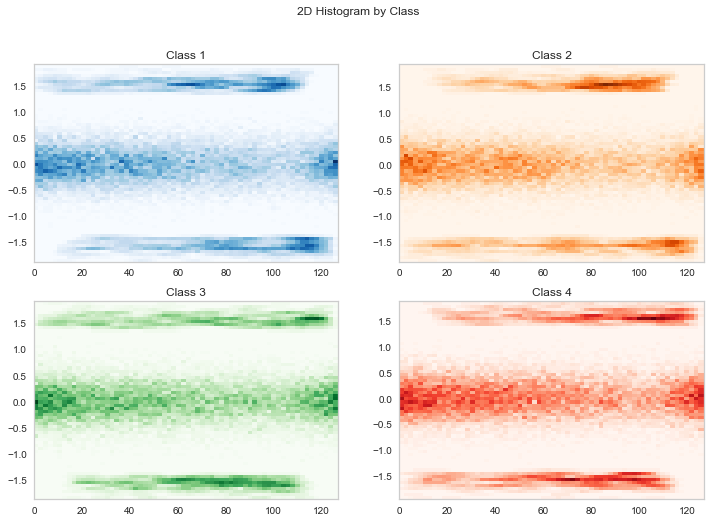

In [235]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('2D Histogram by Class')

colors = ['Blues', 'Oranges', 'Greens', 'Reds']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    melted = X_train[y_train == index + 1].melt()
    length = melted.shape[0]
    ax[x, y].hist2d(x = melted['variable'], y = melted['value'],
                    bins=X_train.shape[1] / 2, cmap=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

## Mean by Position

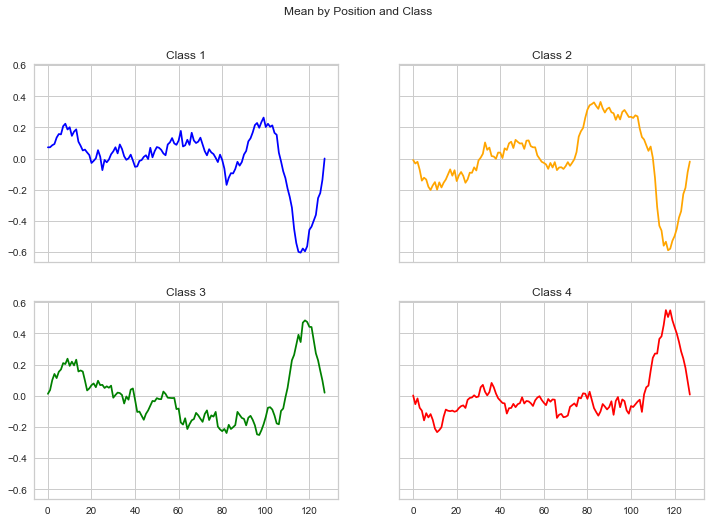

In [236]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('Mean by Position and Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    ax[x, y].plot(X_train[y_train == index + 1].mean(), color=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

## Variance by Position

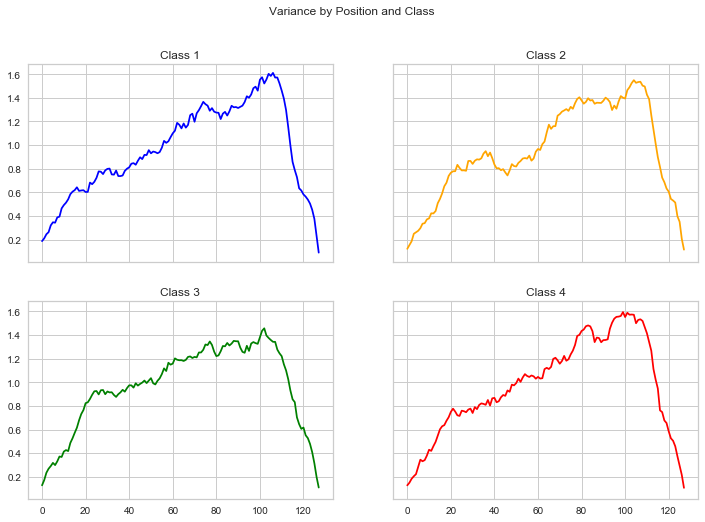

In [237]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('Variance by Position and Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    ax[x, y].plot(X_train[y_train == index + 1].var(), color=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

# XGBoost

## Model

In [85]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [86]:
boost.fit(X_train, y_train, verbose=True)
pred = boost.predict(X_test)

## Results

Accuracy 0.77825


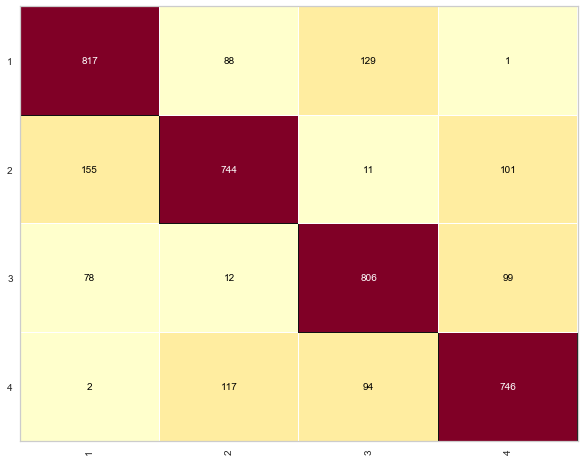

In [87]:
plt.figure(figsize=(10,8))
cm = ConfusionMatrix(boost, classes=[1,2,3,4])
cm.fit(X_train, y_train)
print(f'Accuracy {cm.score(X_test, y_test)}')

In [88]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       0.79      0.78      0.78      1052
           2       0.74      0.77      0.75       961
           3       0.81      0.78      0.79      1040
           4       0.78      0.79      0.78       947

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



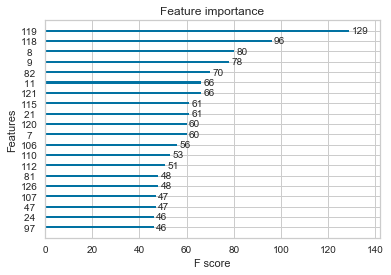

In [89]:
xgb.plot_importance(boost, max_num_features=20);

# Feature Generation
* We want ergodic features
* Ergodic features will converge to stable values we add more data
* A random work, for example, does not have ergodicity
* If we used a sample of our timeseries to generate features:
    * We'd like those features to be similar if we generated them from a different sample
    * Ergodicity is weaker than stationarity
    * Stationarity means that the statistical properties will be the same

In [168]:
X_train_gen = X_train.copy()
X_test_gen  = X_test.copy()

## Mean & Variance

In [177]:
X_train_gen['mean'] = X_train_gen.iloc[:,0:128].mean(axis=1)
X_train_gen['mean20'] = X_train_gen.iloc[:,0:20].mean(axis=1)
X_train_gen['mean110'] = X_train_gen.iloc[:,110:128].mean(axis=1)
X_train_gen['variance'] = X_train_gen.iloc[:,0:128].var(axis=1)

X_test_gen['mean'] = X_test_gen.iloc[:,0:128].mean(axis=1)
X_test_gen['mean20'] = X_test_gen.iloc[:,0:20].mean(axis=1)
X_test_gen['mean110'] = X_test_gen.iloc[:,110:128].mean(axis=1)
X_test_gen['variance'] = X_test_gen.iloc[:,0:128].var(axis=1)

## Min & Max

In [170]:
X_train_gen['min'] = X_train_gen.iloc[:,0:128].min(axis=1)
X_train_gen['max'] = X_train_gen.iloc[:,0:128].max(axis=1)

X_test_gen['min'] = X_test_gen.iloc[:,0:128].min(axis=1)
X_test_gen['max'] = X_test_gen.iloc[:,0:128].max(axis=1)

## Points Above Threshold

In [171]:
X_train_gen['above_pos1'] = (X_train_gen.iloc[:,0:128] > 1.0).sum(axis=1)
X_train_gen['below_neg1'] = (X_train_gen.iloc[:,0:128] < -1.0).sum(axis=1)

X_test_gen['above_pos1'] = (X_test_gen.iloc[:,0:128] > 1.0).sum(axis=1)
X_test_gen['below_neg1'] = (X_test_gen.iloc[:,0:128] < -1.0).sum(axis=1)

## Extra Feature Ideas
* Periodicity
* Smoothness
* Autocorrelation

## Model

In [178]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [179]:
boost.fit(X_train_gen, y_train, verbose=True)
pred = boost.predict(X_test_gen)

## Results

Accuracy 0.81125


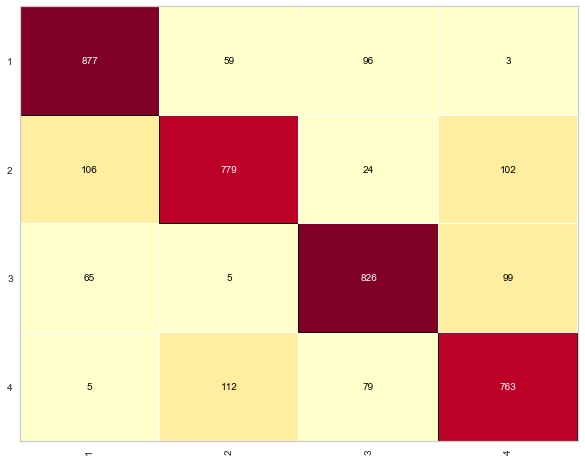

In [180]:
plt.figure(figsize=(10,8))
cm = ConfusionMatrix(boost, classes=[1,2,3,4])
cm.fit(X_train_gen, y_train)
print(f'Accuracy {cm.score(X_test_gen, y_test)}')

In [181]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       0.85      0.83      0.84      1053
           2       0.77      0.82      0.79       955
           3       0.83      0.81      0.82      1025
           4       0.80      0.79      0.79       967

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



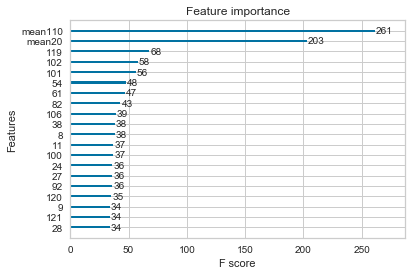

In [182]:
xgb.plot_importance(boost, max_num_features=20);

## Observation
* Using some of the visuals provided some insights
* Moved up from 77.8% to 81.1% accuracy
* Need deeper domain expertise to continue finding features to improve

# TSFresh
* FeatuRe Extraction based on Scalable Hypothesis
* Handles automatic:
    * Freature generation
    * Imputation of missing generated features
    * Statisical selection of features 
* There is another similar library in python called cesium for feature generation

## Melting Data
* Our data is in wide format (training cases by time series 0-127)
* We need it in long format for processing by the tsfresh library
* This involves moving each row - column cell to its own row
    * Row 1 : case 0, series @ time 0
    * Row 2 : case 0, series @ time 1
    * ...
    * Row 127,999 : case 999 @ time 126
    * Row 127,999 : case 999 @ time 127

In [131]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.230379,0.490966,0.358833,-0.230965,0.090225,-0.501473,-0.339329,0.066836,0.232949,0.028326,...,-1.680129,-1.680129,0.105036,-0.264838,0.306594,-0.075228,-0.222192,0.210745,-0.255429,-0.278942
1,0.000765,-0.342680,0.188729,-0.479362,-0.281932,0.351927,-0.360330,0.121821,-0.285499,0.085623,...,0.148473,-0.221473,-0.090350,0.606164,-0.589216,-0.187478,-0.189875,-0.642700,-0.121495,0.525895
2,0.170442,-0.018864,0.402452,-0.075797,0.156014,-0.150981,-0.171141,-0.179950,-0.108274,0.175447,...,0.098403,-0.122188,-0.043269,-0.205324,0.093592,0.346100,-0.508802,-0.220517,0.257965,0.662665
3,0.239996,0.709401,-0.686034,0.615863,-0.345213,-0.677124,-0.890195,-0.150061,-0.183684,-0.555484,...,-0.185940,-0.291869,0.181239,-0.404985,0.282751,0.065136,-0.389442,-0.034956,0.548547,-0.599219
4,0.404257,0.824277,-0.427975,-0.345740,0.461754,0.211839,0.395389,0.009144,-0.173102,-0.102791,...,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-0.227913,-0.002611,-0.482962


In [55]:
X_train_fresh = X_train.copy()
X_train_fresh['id'] = X_train_fresh.index

X_test_fresh = X_test.copy()
X_test_fresh['id'] = X_test_fresh.index

In [56]:
X_train_melt = X_train_fresh.melt(id_vars=['id']).sort_values(['id', 'variable'])
X_test_melt  = X_test_fresh.melt(id_vars=['id']).sort_values(['id', 'variable'])

In [57]:
X_train_melt.head()

,id,variable,value
0,0,0,0.230379
1000,0,1,0.490966
2000,0,2,0.358833
3000,0,3,-0.230965
4000,0,4,0.090225


## Fresh
* http://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [58]:
extracted_features_train = extract_features(X_train_melt, column_id='id', column_sort='variable',
                                            default_fc_parameters = EfficientFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


In [59]:
extracted_features_test = extract_features(X_test_melt, column_id='id', column_sort='variable',
                                            default_fc_parameters = EfficientFCParameters())

Feature Extraction: 100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


In [60]:
extracted_features_train['id'] = extracted_features_train.index
extracted_features_test['id'] = extracted_features_test.index
extracted_features_train.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation,id
id,,,,,,,,,,,,,,,,,,,,,
0,126.999996,47.507281,-0.025816,-0.039493,0.061734,0.812041,0.048913,0.007232,0.044528,1.296750,...,1.0,0.003737,0.003748,0.037527,0.0,0.0,0.0,0.992187,0.0,0
1,127.000005,44.062107,-0.051069,-0.082273,0.073895,0.438416,0.188310,0.044643,0.070200,0.892825,...,1.0,0.014600,0.019763,0.032091,0.0,0.0,0.0,0.992188,0.0,1
2,126.999996,37.095608,0.037128,0.087348,0.171839,0.614938,0.236146,0.032305,0.040080,0.924699,...,1.0,-0.115444,-0.248660,-0.378493,0.0,0.0,0.0,0.992187,0.0,2
3,127.000003,44.085770,-0.058750,-0.089559,0.069194,0.743966,-0.046678,-0.007682,0.049566,0.881954,...,1.0,-0.160018,-0.318326,-0.491053,0.0,0.0,0.0,0.992188,0.0,3
4,127.000001,39.536780,-0.008761,0.029453,0.127952,0.429171,0.368192,0.057298,0.043625,0.984174,...,1.0,0.007258,0.003714,-0.011471,0.0,0.0,0.0,0.992188,0.0,4


## Combined Model

In [61]:
X_train_combined = pd.merge(X_train_fresh, extracted_features_train, left_on='id', right_on='id')
X_test_combined = pd.merge(X_test_fresh,   extracted_features_test,  left_on='id', right_on='id')

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: 'id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
X_train_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
0,0.230379,0.490966,0.358833,-0.230965,0.090225,-0.501473,-0.339329,0.066836,0.232949,0.028326,...,1.0,1.0,0.003737,0.003748,0.037527,0.0,0.0,0.0,0.992187,0.0
1,0.000765,-0.342680,0.188729,-0.479362,-0.281932,0.351927,-0.360330,0.121821,-0.285499,0.085623,...,1.0,1.0,0.014600,0.019763,0.032091,0.0,0.0,0.0,0.992188,0.0
2,0.170442,-0.018864,0.402452,-0.075797,0.156014,-0.150981,-0.171141,-0.179950,-0.108274,0.175447,...,1.0,1.0,-0.115444,-0.248660,-0.378493,0.0,0.0,0.0,0.992187,0.0
3,0.239996,0.709401,-0.686034,0.615863,-0.345213,-0.677124,-0.890195,-0.150061,-0.183684,-0.555484,...,1.0,1.0,-0.160018,-0.318326,-0.491053,0.0,0.0,0.0,0.992188,0.0
4,0.404257,0.824277,-0.427975,-0.345740,0.461754,0.211839,0.395389,0.009144,-0.173102,-0.102791,...,1.0,1.0,0.007258,0.003714,-0.011471,0.0,0.0,0.0,0.992188,0.0


In [63]:
X_test_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
0,0.092276,-0.223990,0.147545,-0.431031,-0.304397,0.244396,-0.144781,0.299219,-0.443211,0.259552,...,1.0,1.0,0.017391,0.013285,0.011656,0.0,0.0,0.0,0.992188,0.0
1,-0.283450,-0.326020,0.330485,0.061099,-0.285491,0.085344,0.672175,-0.043962,-0.177207,0.192364,...,1.0,1.0,0.024045,0.041136,0.047244,0.0,0.0,0.0,0.992188,0.0
2,-0.430795,0.155334,-0.721453,-0.102576,-0.332756,0.101725,-0.432919,0.276727,0.386408,0.144596,...,1.0,1.0,0.105443,0.206751,0.320026,0.0,0.0,0.0,0.992188,0.0
3,-0.531494,0.103033,0.323408,-0.616874,0.179767,-0.111653,-0.180944,-0.181608,0.437917,0.117363,...,1.0,1.0,0.001556,0.039246,0.082008,0.0,0.0,0.0,0.992187,0.0
4,-0.153574,-0.087640,-0.240677,-0.202274,-0.115275,0.021871,-0.123556,-0.181116,0.062237,-0.127736,...,1.0,1.0,0.010284,0.015169,0.003899,0.0,0.0,0.0,0.992187,0.0


In [64]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [65]:
boost.fit(X_train_combined, y_train, verbose=True)
pred = boost.predict(X_test_combined)

Accuracy 0.99425


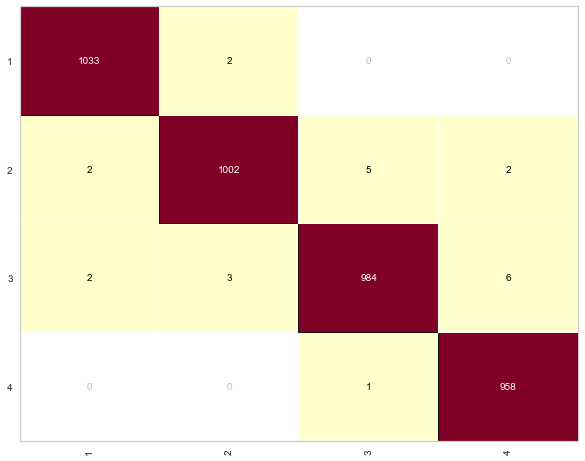

In [66]:
plt.figure(figsize=(10,8))
cm = ConfusionMatrix(boost, classes=[1,2,3,4])
cm.fit(X_train_combined, y_train)
print(f'Accuracy {cm.score(X_test_combined, y_test)}')

In [67]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1037
           2       0.99      1.00      0.99      1007
           3       0.99      0.99      0.99       990
           4       1.00      0.99      1.00       966

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



## Derived Features
* What if we use only the derived tsfresh features?

In [68]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [69]:
boost.fit(extracted_features_train, y_train, verbose=True)
pred = boost.predict(extracted_features_test)

Accuracy 0.9945


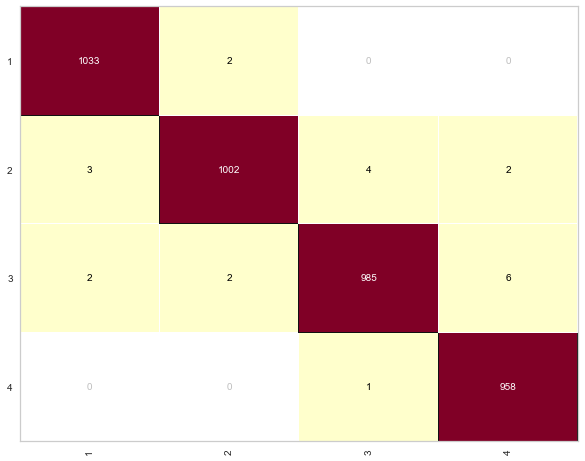

In [70]:
plt.figure(figsize=(10,8))
cm = ConfusionMatrix(boost, classes=[1,2,3,4])
cm.fit(extracted_features_train, y_train)
print(f'Accuracy {cm.score(extracted_features_test, y_test)}')

In [71]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1038
           2       0.99      1.00      0.99      1006
           3       0.99      0.99      0.99       990
           4       1.00      0.99      1.00       966

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



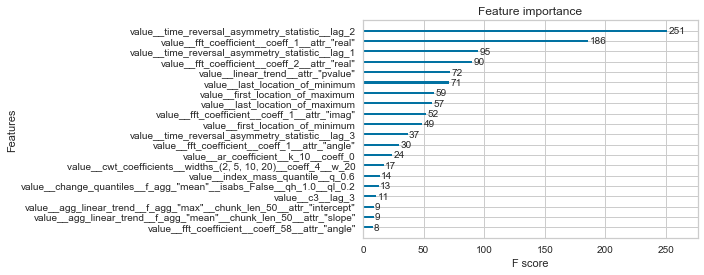

In [72]:
xgb.plot_importance(boost, max_num_features=20);

## Comparison

In [73]:
baseline = UCR_UEA_datasets().baseline_accuracy('TwoPatterns')['TwoPatterns']
baselineDF = pd.DataFrame(baseline, index=[0]).T
baselineDF.columns=['Accuracy']
baselineDF.sort_values('Accuracy', ascending=False)

,Accuracy
WDTW_1NN,1.00000
DTW_R1_1NN,1.00000
Flat-COTE,1.00000
EE,1.00000
DTW_F,1.00000
DD_DTW,1.00000
ERP_1NN,1.00000
HIVE-COTE,1.00000
DTD_C,0.99950
LCSS_1NN,0.99925


# Dynamic Time Warping & 1 K-Nearest Neighbors
* The idea here is to combine 
    * Known labels in train set
    * Series we want to predict in the test set
* Use a similarity method for two time series called dynamic time warping
* Select the closest KNN match as the predicted label
* fastdtw library in python

##  Distance

In [245]:
from IPython.core.display import display, HTML
display(HTML('<img src="https://databricks.com/wp-content/uploads/2019/04/Euclidean_vs_DTW.jpg"/>'))

## Dynamic Time Warping (DTW)
* Measurement of similarity between two time series
* Good metric when the overall shape is very important 
* Takes into account variations in speed
* Think DTW helping you to identify speech
    * You could be talking normally or quickly
    * The speech looks the same but isn't perfectly aligned
    * It could be squashed or expanded

## Algorithm
* Compute the euclidean distance between all points (builds a distance matrix)
* Find minimum distance path subject between two series
* Every point in one series must be matched to one point in the other
* Matrix, Memoization, Recursion = Dynamic Programming

In [2]:
from IPython.core.display import display, HTML
display(HTML('<img src="https://images.squarespace-cdn.com/content/v1/55ff6aece4b0ad2d251b3fee/1464982207050-6NMOJG09VRX9H98UHDYW/ke17ZwdGBToddI8pDm48kMHrIFLKwvePJPdAyGkbgngUqsxRUqqbr1mOJYKfIPR7QNOqSm-JBvQdE_GChQ7ORrNVB1TC0aTx3_rbljJ3eoCWLDNqMSc4DWlCiiUwFevKInPi9iDjx9w8K4ZfjXt2djcUAuH31NlRrjMR1nb9ZnY9vBtTqv5NHPBqvROf8vbqCjLISwBs8eEdxAxTptZAUg/DTW-Figure2-EuclideanDistance?format=1500w"/>'))

## Optimizations to DTW
* Boundary - Must start and end on bottom left - top right
* Monotonicity - Cannot go back in time
* Continuity - Cannot jump
* Warping - How far of a window from the diagonal

## DTW-KNN
* Not a library that I could find that combines this into an Estimator
* There are a few reference implementations in github repos
* https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

In [189]:
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    if dm_count % 1000 == 0:
                        print(f'Completed {dm_count}')
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    if dm_count % 1000 == 0:
                        print(f'Completed {dm_count}')
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

## Train

In [4]:
# 4000 Test * 1000 Train * .1 Seconds / 3600 Seconds in Hour
print(f'Estimated Hours {4000*1000*.1/3600:.2f}')

Estimated Hours 111.11


In [191]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')
X_train_dtw = X_train[0:200]
X_test_dtw  = X_test [0:200]
y_train_dtw = y_train[0:200]
y_test_dtw  = y_test [0:200]

In [5]:
# 4000 Test * 1000 Train * .1 Seconds / 3600 Seconds in Hour
print(f'Sample - Estimated Hours {200*200*.1/3600:.2f}')

Sample - Estimated Hours 1.11


In [192]:
model = KnnDtw(n_neighbors=1, max_warping_window=10)
model.fit(X_train_dtw, y_train_dtw)
label, proba = model.predict(X_test_dtw)

Completed 1000
Completed 2000
Completed 3000
Completed 4000
Completed 5000
Completed 6000
Completed 7000
Completed 8000
Completed 9000
Completed 10000
Completed 11000
Completed 12000
Completed 13000
Completed 14000
Completed 15000
Completed 16000
Completed 17000
Completed 18000
Completed 19000
Completed 20000
Completed 21000
Completed 22000
Completed 23000
Completed 24000
Completed 25000
Completed 26000
Completed 27000
Completed 28000
Completed 29000
Completed 30000
Completed 31000
Completed 32000
Completed 33000
Completed 34000
Completed 35000
Completed 36000
Completed 37000
Completed 38000
Completed 39000
Completed 40000


In [193]:
accuracy = accuracy_score(label, y_test_dtw)
print(f'DWT+1KNN {accuracy}')

DWT+1KNN 0.975


## Note:
* For this dataset 1000 X 4000 comparisons would be needed 
* This is a small set 200 X 200 (and achieving 97.5%)
* 100 X 100 achieved 92.5%

# Conclusion
* Generating features is computationally expensive for time series
    * TSFresh & Cesium can run for long periods of time
    * DTW is expensive (Use fast implementation)
    * Experiment with small samples, small numbers of features
* Clustering Time Series
    * Comparable to other clustering problems
    * Extract featuers & compute distance
    * Distance Metric (Euclidean, DTW, Features)
    * Clustering Algorithm (KMeans, Agglomerative, DBScan, etc)